# Description: 
Perform Sentiment Analysis by scraping reviews from yelp

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import re
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Download the stopwords list if you haven't already


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrobi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Collect Yelp Review

In [12]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [13]:
# Create a dataframe with a column called Review
df = pd.DataFrame(np.array(reviews), columns = ['review'])
# Show the first 5 rows of data
df.head()

,review
0,Very cute coffee shop and restaurant. They hav...
1,Six of us met here for breakfast before our wa...
2,We came for brunch and they ran out of seven s...
3,Great place with delicious food and friendly s...
4,The food was delicious. The ricotta pancakes w...


#### `Preprocessing` and `Cleaning` reviews

In [14]:
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}



In [15]:
## Conversion of contraction to Expansion
def cont_to_expa(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x 


## Remove Accented Chars
import unicodedata
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'igonore')
    return x


# Convert into base or root form of word
def make_to_base(x):
    x_list = []
    doc = nlp(x)

    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    print(" ".join(x_list))

In [16]:
# Define stop words
stop_words = set(stopwords.words('english'))

In [17]:
# Clean the text
# Create a function to clean the tweets
def prep_clean(text):

    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text) # Remove emails
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', '', text) # Remove urls
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = " ".join(text.split()) # Remove multiple space
    text = BeautifulSoup(text, 'lxml').get_text() # Reomve HTML tags
    text = remove_accented_chars(text) # Remove Accented Chars
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removed @mentioned
    text = re.sub(r'#', '', text) # Removing the '#' symbol
    text = re.sub('[^A-Z a-z 0-9-]+', '', text) # Special characters or punctuation removal

    text = text.lower()
    text = cont_to_expa(text) # Contraction to Expansion
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

# Cleaning the text
df['review'] = df['review'].apply(lambda text: prep_clean(text))

# Show the cleaned text
df.head()

,review
0,cute coffee shop restaurant lovely outdoor sea...
1,six us met breakfast walk manly enjoying visit...
2,came brunch ran seven separate menu items trie...
3,great place delicious food friendly staff smal...
4,food delicious ricotta pancakes light tasty cr...


In [18]:
### check
x = 'thanks     for watching .   @email        and please  like this         video!!!'
prep_clean(x)

'thanks watching please like video'

In [19]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['review'].apply(getSubjectivity)
df['Polarity'] = df['review'].apply(getPolarity)

# Show the new dataframe with the new columns
df

,review,Subjectivity,Polarity
0,cute coffee shop restaurant lovely outdoor sea...,0.589216,0.373529
1,six us met breakfast walk manly enjoying visit...,0.596860,0.386957
2,came brunch ran seven separate menu items trie...,0.511455,0.097143
3,great place delicious food friendly staff smal...,0.609259,0.452778
4,food delicious ricotta pancakes light tasty cr...,0.460000,0.400000
5,ricotta hot cakes yummy ate pretty fast didnt ...,0.731250,0.337500
6,great food amazing coffee tea short walk harbo...,0.612500,0.443750
7,great service lovely location really amazing f...,0.409833,0.236833
8,came brunch twice week-long visit sydney every...,0.460417,0.213021
9,ok coffee friends im new area still need disco...,0.469697,0.257576


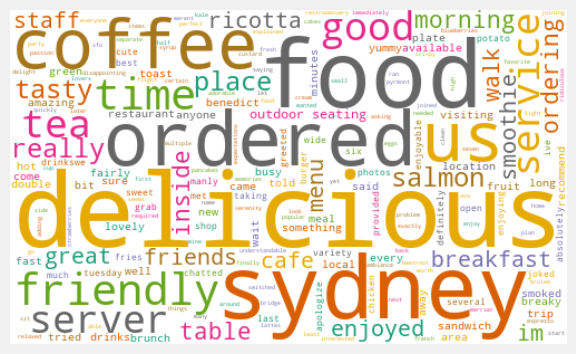

In [20]:
# Plot the Word Cloud
allWords = ' '.join([twts for twts in df['review']] )
wordCloud = WordCloud(width = 500, height = 300, background_color="white", colormap="Dark2", 
random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [21]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

# show the dataframe
df

,review,Subjectivity,Polarity,Analysis
0,cute coffee shop restaurant lovely outdoor sea...,0.589216,0.373529,Positive
1,six us met breakfast walk manly enjoying visit...,0.596860,0.386957,Positive
2,came brunch ran seven separate menu items trie...,0.511455,0.097143,Positive
3,great place delicious food friendly staff smal...,0.609259,0.452778,Positive
4,food delicious ricotta pancakes light tasty cr...,0.460000,0.400000,Positive
5,ricotta hot cakes yummy ate pretty fast didnt ...,0.731250,0.337500,Positive
6,great food amazing coffee tea short walk harbo...,0.612500,0.443750,Positive
7,great service lovely location really amazing f...,0.409833,0.236833,Positive
8,came brunch twice week-long visit sydney every...,0.460417,0.213021,Positive
9,ok coffee friends im new area still need disco...,0.469697,0.257576,Positive


In [22]:
# Print all of the positive tweets
j = 1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
  if (sortedDF['Analysis'][i] == 'Positive'): 
    print(str(j) + ') ' + sortedDF['review'][i])
    print()
    j = j + 1

1) cute coffee shop restaurant lovely outdoor seating area several tables inside fairly busy tuesday morning grab last open table server enjoyable chatted joked us provided fast service ordering drinks meals food good ordered wide variety every meal good delicious sweet potato fries chicken burger plate absolutely delicious best ive ever definitely enjoyed cafe outdoor seating service food

2) six us met breakfast walk manly enjoying visiting much apologize taking photos enjoyed food well coffee tea drinkswe greeted immediately friendly server asking would like sit inside said would like inside werent exactly sure many joining us yet- least 4 told problem merrier minutes later 4 joined party explained server 6 quickly switched table really enjoyed serenity tea needed long flight sfo morning everyone else interested lattes expresso drinks said hot delicious 2 us ordered avo toast yummy beetroot start adding mine home fond memories trip sydney 2 friends ordered salmon benedict- saying de

In [23]:
# print the negative tweets
# j = 1
# sortedDF = df.sort_values(by=['Polarity'], ascending = False)
# for i in range(0, sortedDF.shape[0]):
#   if (sortedDF['Analysis'][i] == 'Negative'):
#     print(str(j) + ') '+ sortedDF['Tweets'][i])
#     print()
#     j = j + 1

Text(0, 0.5, 'Subjectivity')

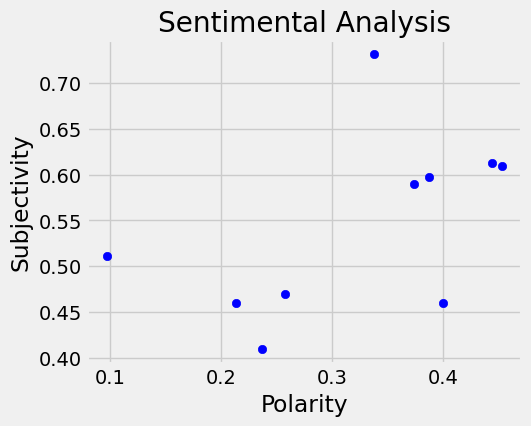

In [24]:
# Plot the polarity and subjectivity
plt.figure(figsize=(5, 4))
for i in range(0, df.shape[0]):
  plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue')

plt.title("Sentimental Analysis")
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [25]:
# Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['review']

round((ptweets.shape[0] / df.shape[0]) * 100, 1)

100.0

In [26]:
# Get the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['review']

round((ntweets.shape[0] / df.shape[0]) * 100, 1)

0.0

Analysis
Positive    10
Name: count, dtype: int64


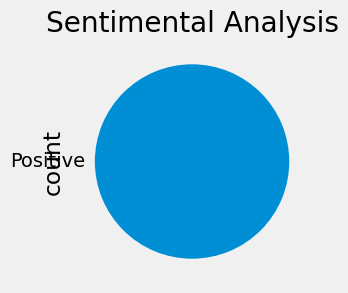

In [27]:
# Show the value counts
print(df['Analysis'].value_counts())

# plot and visualize the counts
plt.figure(figsize=(4, 3))
plt.title('Sentimental Analysis')
df['Analysis'].value_counts().plot(kind='pie')
plt.show()

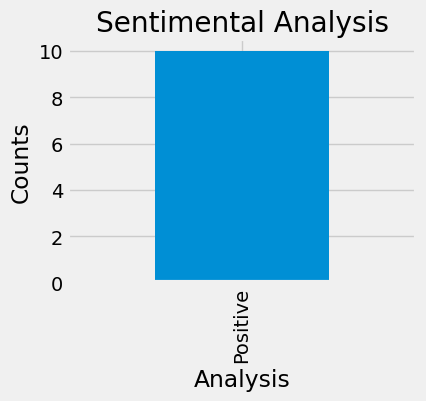

In [28]:
# Show the value counts
df['Analysis'].value_counts()
plt.figure(figsize=(4, 3))
# plot and visualize the counts
plt.title('Sentimental Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='bar')
plt.show()